In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Custom transformers and base classes
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing and feature engineering
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Imputation
from sklearn.experimental import enable_iterative_imputer  # Enable experimental features
from sklearn.impute import IterativeImputer, SimpleImputer

# Feature selection
from sklearn.feature_selection import SelectKBest, f_regression

# Model selection and evaluation
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    StackingRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

# Model interpretation
import shap

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

## Loading data and merging features and labels

In [ ]:
# Load data
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')

# Merge features and labels
data = train_labels.merge(train_features, on='uid', how='left')

data.head()


,uid,year,composite_score,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,2021,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,2021,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
2,aape,2016,161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,6.2 or 3 times a month,2.4 or more times a week,0.No,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
3,aape,2021,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,6.2 or 3 times a month,2.4 or more times a week,0.No,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
4,aard,2021,104,1. 50–59,"1. 100,000+",3. Widowed,1.0,3. 7–9 years,1. 1 or 2,0.0,...,1.very important,4.Once a week,9.Never,1.Yes,NaN,NaN,NaN,NaN,No 2,Concrete 2


## Dropping columns with excessive missing data
Defined as more than 50% of values missing

In [ ]:
# Drop columns with excessive missing data
missing_threshold = 0.5
missing_percentages = data.isnull().mean()
cols_to_drop = missing_percentages[missing_percentages > missing_threshold].index.tolist()
data = data.drop(columns=cols_to_drop, errors='ignore')

## Identifying numerical and categorical columns

In [ ]:
# Identify numerical and categorical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

## Separating ordinal and nominal categorical columns

In [ ]:
# Identify ordinal variables based on data descriptions
ordinal_variables = [
    'age_03',              # Binned age group
    'edu_gru_03',          # Binned education level
    'n_living_child_03',   # Binned number of living children
    'glob_hlth_03',        # Self-reported global health
    'age_12',              # Binned age group
    'edu_gru_12',          # Binned education level
    'n_living_child_12',   # Binned number of living children
    'glob_hlth_12',        # Self-reported global health
    'bmi_12',              # Binned body mass index
    'decis_famil_12',      # Weight in family decisions
    'decis_personal_12',   # Weight over personal decisions
    'satis_ideal_12',      # Agreement with life satisfaction statements
    'satis_excel_12',
    'satis_fine_12',
    'cosas_imp_12',
    'wouldnt_change_12',
    'memory_12',           # Self-reported memory
    'rameduc_m',           # Mother's education level
    'rafeduc_m',           # Father's education level
    'rrelgimp_03',         # Importance of religion
    'rrelgimp_12',
    'rrfcntx_m_12',        # Frequency of seeing friends/relatives
    'rsocact_m_12',        # Frequency of social activities
    'rrelgwk_12',          # Participation in weekly religious services
    'a34_12'               # English proficiency
]

# Nominal variables are the rest of the categorical variables
nominal_variables = [col for col in categorical_cols if col not in ordinal_variables]

# Exclude 'uid' from nominal variables
if 'uid' in nominal_variables:
    nominal_variables.remove('uid')

# Output the lists
print(f"Ordinal variables ({len(ordinal_variables)}): {ordinal_variables}\n")
print(f"Nominal variables ({len(nominal_variables)}): {nominal_variables}\n")

Ordinal variables (25): ['age_03', 'edu_gru_03', 'n_living_child_03', 'glob_hlth_03', 'age_12', 'edu_gru_12', 'n_living_child_12', 'glob_hlth_12', 'bmi_12', 'decis_famil_12', 'decis_personal_12', 'satis_ideal_12', 'satis_excel_12', 'satis_fine_12', 'cosas_imp_12', 'wouldnt_change_12', 'memory_12', 'rameduc_m', 'rafeduc_m', 'rrelgimp_03', 'rrelgimp_12', 'rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12', 'a34_12']

Nominal variables (11): ['urban_03', 'married_03', 'employment_03', 'urban_12', 'married_12', 'employment_12', 'ragender', 'sgender_03', 'sgender_12', 'rjlocc_m_12', 'j11_12']



### Creating a custom mapping for ordinal variables

In [ ]:
# Mappings for ordinal variables
age_mapping = {
    '0. 49 or younger': 0,
    '1. 50–59': 1,
    '2. 60–69': 2,
    '3. 70–79': 3,
    '4. 80+': 4,
}

education_mapping = {
    '0. No education': 0,
    '1. 1–5 years': 1,
    '2. 6 years': 2,
    '3. 7–9 years': 3,
    '4. 10+ years': 4,
}

n_living_child_mapping = {
    '0. No children': 0,
    '1. 1 or 2': 1,
    '2. 3 or 4': 2,
    '3. 5 or 6': 3,
    '4. 7+': 4,
}

glob_health_mapping = {
    '1. Excellent': 5,
    '2. Very good': 4,
    '3. Good': 3,
    '4. Fair': 2,
    '5. Poor': 1,
}

bmi_mapping = {
    '1. Underweight': 1,
    '2. Normal weight': 2,
    '3. Overweight': 3,
    '4. Obese': 4,
    '5. Morbidly obese': 5,
}

decis_famil_mapping = {
    '1. Respondent': 1,
    '2. Approximately equal weight': 2,
    '3. Spouse': 3,
}

decis_personal_mapping = {
    '1. A lot': 3,
    '2. A little': 2,
    '3. None': 1
}

agreement_mapping = {
    '1. Agrees': 3,
    '2. Neither agrees nor disagrees': 2,
    '3. Disagrees': 1,
}

memory_mapping = {
    '1. Excellent': 5,
    '2. Very good': 4,
    '3. Good': 3,
    '4. Fair': 2,
    '5. Poor': 1,
}

parent_education_mapping = {
    '1.None': 1,
    '2.Some primary': 2,
    '3.Primary': 3,
    '4.More than primary': 4,
}

religion_importance_mapping = {
    '1.very important': 3,
    '2.somewhat important': 2,
    '3.not important': 1,
}

frequency_mapping = {
    '1.Almost every day': 9,
    '2.4 or more times a week': 8,
    '3.2 or 3 times a week': 7,
    '4.Once a week': 6,
    '5.4 or more times a month': 5,
    '6.2 or 3 times a month': 4,
    '7.Once a month': 3,
    '8.Almost Never, sporadic': 2,
    '9.Never': 1,
}

religious_services_mapping = {
    '1.Yes': 1,
    '0.No': 0,
}

english_proficiency_mapping = {
    'Yes 1': 1,
    'No 2': 0,
}

# Compile all mappings into a dictionary for easy access
ordinal_mappings = {
    'age_03': age_mapping,
    'age_12': age_mapping,
    'edu_gru_03': education_mapping,
    'edu_gru_12': education_mapping,
    'n_living_child_03': n_living_child_mapping,
    'n_living_child_12': n_living_child_mapping,
    'glob_hlth_03': glob_health_mapping,
    'glob_hlth_12': glob_health_mapping,
    'bmi_12': bmi_mapping,
    'decis_famil_12': decis_famil_mapping,
    'decis_personal_12': decis_personal_mapping,
    'satis_ideal_12': agreement_mapping,
    'satis_excel_12': agreement_mapping,
    'satis_fine_12': agreement_mapping,
    'cosas_imp_12': agreement_mapping,
    'wouldnt_change_12': agreement_mapping,
    'memory_12': memory_mapping,
    'rameduc_m': parent_education_mapping,
    'rafeduc_m': parent_education_mapping,
    'rrelgimp_03': religion_importance_mapping,
    'rrelgimp_12': religion_importance_mapping,
    'rrfcntx_m_12': frequency_mapping,
    'rsocact_m_12': frequency_mapping,
    'rrelgwk_12': religious_services_mapping,
    'a34_12': english_proficiency_mapping,
}


## Feature engineering

### 1. Creating Temporal Features:
- Change Over Time: For individuals with data from both 2003 and 2012, calculate the change or rate of change in features over time.
- Duration Since Last Measurement: Include the time gap between the last available feature data and the target year.

#### Identify Features for Change Calculation
We'll focus on numerical and ordinal variables suitable for calculating changes.

In [ ]:
# Adjust the temporal features handling to match existing columns
common_features = set([col[:-3] for col in data.columns if col.endswith('_03')]) & \
                  set([col[:-3] for col in data.columns if col.endswith('_12')])

# Filter common features that are numerical or ordinal
numerical_common_features = [feature for feature in common_features if feature + '_03' in numerical_cols or feature + '_12' in numerical_cols]

# Redefine temporal features to only include those present in the dataset
temporal_features = [feature + '_change' for feature in numerical_common_features] + ['time_gap']

# Ensure numerical_common_features and temporal features are aligned with the dataset
numerical_common_features = [feature for feature in numerical_common_features if feature + '_03' in data.columns and feature + '_12' in data.columns]

# Verify adjusted temporal features
temporal_features, numerical_common_features


(['hinc_assets_change',
  'lonely_change',
  'n_illnesses_change',
  'issste_change',
  'alcohol_change',
  'sad_change',
  'test_pres_change',
  'visit_med_change',
  'insured_change',
  'energetic_change',
  'depressed_change',
  'exer_3xwk_change',
  'hypertension_change',
  'iadl_money_change',
  'hinc_rent_change',
  'sinc_pension_change',
  'adl_bed_change',
  'n_adl_change',
  'hincome_change',
  'rinc_pension_change',
  'enjoy_change',
  'migration_change',
  'adl_toilet_change',
  'visit_dental_change',
  'test_tuber_change',
  'hosp_change',
  'stroke_change',
  'iadl_shop_change',
  'adl_walk_change',
  'hrt_attack_change',
  'arthritis_change',
  'decis_personal_change',
  'n_depr_change',
  'tobacco_change',
  'adl_bath_change',
  'iadl_meals_change',
  'restless_change',
  'rearnings_change',
  'searnings_change',
  'insur_private_change',
  'n_mar_change',
  'adl_dress_change',
  'cesd_depressed_change',
  'insur_other_change',
  'tired_change',
  'test_chol_change',
  '

In [ ]:
len(temporal_features)

61

In [ ]:
len(numerical_common_features)

60

### Creating custom transformers for the temporal features' creation

In [ ]:
class TemporalFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_common_features, ordinal_mappings):
        self.numerical_common_features = numerical_common_features
        self.ordinal_mappings = ordinal_mappings
        
    def fit(self, X, y=None):
        return self  # Nothing to fit

    def transform(self, X):
        X = X.copy()
        
        # Handle ordinal variables
        for feature in self.numerical_common_features:
            base_feature = feature  # e.g., 'age', 'edu_gru'
            col_03 = feature + '_03'
            col_12 = feature + '_12'
            change_col = feature + '_change'

            # Map ordinal variables if necessary
            if base_feature in self.ordinal_mappings:
                mapping = self.ordinal_mappings[base_feature]
                if col_03 in X.columns:
                    X[col_03] = X[col_03].map(mapping)
                if col_12 in X.columns:
                    X[col_12] = X[col_12].map(mapping)

            # Convert columns to numeric (if not already)
            if col_03 in X.columns:
                X[col_03] = pd.to_numeric(X[col_03], errors='coerce')
            if col_12 in X.columns:
                X[col_12] = pd.to_numeric(X[col_12], errors='coerce')

            # Calculate change: 2012 value - 2003 value
            if col_03 in X.columns and col_12 in X.columns:
                X[change_col] = X[col_12] - X[col_03]
            else:
                X[change_col] = np.nan  # Handle missing columns
        
        # Determine last feature year
        X['last_feature_year'] = X.apply(self.get_last_feature_year, axis=1)

        # Calculate time gap
        X['time_gap'] = X['year'] - X['last_feature_year']
        
        # Drop 'last_feature_year' if not needed
        X.drop(columns=['last_feature_year'], inplace=True)
        
        return X

    @staticmethod
    def get_last_feature_year(row):
        if not pd.isnull(row.get('age_12')):
            return 2012
        elif not pd.isnull(row.get('age_03')):
            return 2003
        else:
            return np.nan  # No data available


### More custom transformers for feature engineering based off of domain knowledge

#### Education

In [ ]:
# Education Progression
class EducationProgressionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self  # Nothing to fit
    
    def transform(self, X):
        X = X.copy()
        if 'edu_gru_03' in X.columns and 'edu_gru_12' in X.columns:
            X['education_transition'] = X['edu_gru_12'] - X['edu_gru_03']
        else:
            X['education_transition'] = np.nan
        return X

#### Marital status

In [ ]:
# Marital status columns
married_cols_03 = [col for col in data.columns if 'married_03' in col]
married_cols_12 = [col for col in data.columns if 'married_12' in col]

In [ ]:
# Marital status stability
class MaritalTransitionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, married_cols_03, married_cols_12):
        self.married_cols_03 = married_cols_03
        self.married_cols_12 = married_cols_12
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        if self.married_cols_03 and self.married_cols_12:
            X['marital_transition'] = (
                X[self.married_cols_03].sum(axis=1) != X[self.married_cols_12].sum(axis=1)
            ).astype(int)
        else:
            X['marital_transition'] = 0
        return X


#### Chronic Illnesses

In [ ]:
# Chronic illness columns
chronic_illness_cols_03 = ['hypertension_03', 'diabetes_03', 'resp_ill_03', 'arthritis_03', 'hrt_attack_03', 'stroke_03', 'cancer_03']
chronic_illness_cols_12 = ['hypertension_12', 'diabetes_12', 'resp_ill_12', 'arthritis_12', 'hrt_attack_12', 'stroke_12', 'cancer_12']

In [ ]:
# Count of chronic illnesses
class ChronicIllnessTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, chronic_illness_cols_03, chronic_illness_cols_12):
        self.chronic_illness_cols_03 = chronic_illness_cols_03
        self.chronic_illness_cols_12 = chronic_illness_cols_12
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Sum chronic illnesses
        X['chronic_illness_count_03'] = X[self.chronic_illness_cols_03].sum(axis=1)
        X['chronic_illness_count_12'] = X[self.chronic_illness_cols_12].sum(axis=1)
        return X


#### Limitations of activities of daily living

In [ ]:
# ADL and IADL columns
adl_cols_03 = ['adl_dress_03', 'adl_walk_03', 'adl_bath_03', 'adl_eat_03', 'adl_bed_03', 'adl_toilet_03']
adl_cols_12 = ['adl_dress_12', 'adl_walk_12', 'adl_bath_12', 'adl_eat_12', 'adl_bed_12', 'adl_toilet_12']
iadl_cols_03 = ['iadl_money_03', 'iadl_meds_03', 'iadl_shop_03', 'iadl_meals_03']
iadl_cols_12 = ['iadl_money_12', 'iadl_meds_12', 'iadl_shop_12', 'iadl_meals_12']

In [ ]:
# Limitations of Activities of daily living count and progression
class ADLIADLTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, adl_cols_03, adl_cols_12, iadl_cols_03, iadl_cols_12):
        self.adl_cols_03 = adl_cols_03
        self.adl_cols_12 = adl_cols_12
        self.iadl_cols_03 = iadl_cols_03
        self.iadl_cols_12 = iadl_cols_12
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Sum ADL limitations
        X['total_adl_limitations_03'] = X[self.adl_cols_03].sum(axis=1)
        X['total_adl_limitations_12'] = X[self.adl_cols_12].sum(axis=1)
        # Sum IADL limitations
        X['total_iadl_limitations_03'] = X[self.iadl_cols_03].sum(axis=1)
        X['total_iadl_limitations_12'] = X[self.iadl_cols_12].sum(axis=1)
        # Calculate progression
        X['adl_iadl_progression'] = (
            (X['total_adl_limitations_12'] + X['total_iadl_limitations_12']) -
            (X['total_adl_limitations_03'] + X['total_iadl_limitations_03'])
        )
        return X


#### Self Reported Health

In [ ]:
# Self Reported Health Change
class HealthAssessmentChangeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        if 'glob_hlth_03' in X.columns and 'glob_hlth_12' in X.columns:
            X['health_self_assessment_change'] = X['glob_hlth_12'] - X['glob_hlth_03']
        else:
            X['health_self_assessment_change'] = np.nan
        return X


#### Mood and depressive sypmtoms

In [ ]:
# Define mood columns
positive_mood_cols_03 = ['happy_03', 'enjoy_03', 'energetic_03']
positive_mood_cols_12 = ['happy_12', 'enjoy_12', 'energetic_12']
negative_mood_cols_03 = ['depressed_03', 'restless_03', 'lonely_03', 'sad_03', 'tired_03']
negative_mood_cols_12 = ['depressed_12', 'restless_12', 'lonely_12', 'sad_12', 'tired_12']


In [ ]:
# Custom transformer to engineer positive and negative mood scores
class MoodScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, positive_mood_cols_03, positive_mood_cols_12, negative_mood_cols_03, negative_mood_cols_12):
        self.positive_mood_cols_03 = positive_mood_cols_03
        self.positive_mood_cols_12 = positive_mood_cols_12
        self.negative_mood_cols_03 = negative_mood_cols_03
        self.negative_mood_cols_12 = negative_mood_cols_12
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Create aggregate scores for positive and negative moods in 2003
        X['positive_mood_score_03'] = X[self.positive_mood_cols_03].sum(axis=1)
        X['negative_mood_score_03'] = X[self.negative_mood_cols_03].sum(axis=1)
        
        # Create aggregate scores for positive and negative moods in 2012
        X['positive_mood_score_12'] = X[self.positive_mood_cols_12].sum(axis=1)
        X['negative_mood_score_12'] = X[self.negative_mood_cols_12].sum(axis=1)
        
        # Calculate mood changes over time
        X['positive_mood_change'] = X['positive_mood_score_12'] - X['positive_mood_score_03']
        X['negative_mood_change'] = X['negative_mood_score_12'] - X['negative_mood_score_03']
        
        return X

#### Exercise

In [ ]:
# Consistency of exercise tracking
class ConsistentExerciseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        if 'exer_3xwk_03' in X.columns and 'exer_3xwk_12' in X.columns:
            X['consistent_exercise'] = ((X['exer_3xwk_03'] == 1) & (X['exer_3xwk_12'] == 1)).astype(int)
        else:
            X['consistent_exercise'] = np.nan
        return X


#### Alcohol and smoking history

In [ ]:
# Lifestyle columns
lifestyle_cols_03 = ['alcohol_03', 'tobacco_03']
lifestyle_cols_12 = ['alcohol_12', 'tobacco_12']

In [ ]:
# Alcohol and smoking tracking
class LifestyleHealthIndexTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lifestyle_cols_03, lifestyle_cols_12):
        self.lifestyle_cols_03 = lifestyle_cols_03
        self.lifestyle_cols_12 = lifestyle_cols_12
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['lifestyle_health_index_03'] = X[self.lifestyle_cols_03].sum(axis=1)
        X['lifestyle_health_index_12'] = X[self.lifestyle_cols_12].sum(axis=1)
        return X


#### Income and insurance


In [ ]:
# Income columns
income_cols_03 = ['rearnings_03', 'searnings_03', 'hincome_03', 'hinc_business_03', 'hinc_rent_03', 'hinc_assets_03', 'hinc_cap_03', 'rinc_pension_03', 'sinc_pension_03']
income_cols_12 = ['rearnings_12', 'searnings_12', 'hincome_12', 'hinc_business_12', 'hinc_rent_12', 'hinc_assets_12', 'hinc_cap_12', 'rinc_pension_12', 'sinc_pension_12']

# Insurance columns
insurance_cols_03 = ['imss_03', 'issste_03', 'pem_def_mar_03', 'insur_private_03', 'insur_other_03', 'insured_03']
insurance_cols_12 = ['imss_12', 'issste_12', 'pem_def_mar_12', 'insur_private_12', 'insur_other_12', 'insured_12']


In [ ]:
# Income and insurance coverage
class SocioeconomicFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, income_cols_03, income_cols_12, insurance_cols_03, insurance_cols_12):
        self.income_cols_03 = income_cols_03
        self.income_cols_12 = income_cols_12
        self.insurance_cols_03 = insurance_cols_03
        self.insurance_cols_12 = insurance_cols_12
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Aggregate income
        X['aggregate_income_03'] = X[self.income_cols_03].sum(axis=1)
        X['aggregate_income_12'] = X[self.income_cols_12].sum(axis=1)
        # Insurance coverage depth
        X['insurance_coverage_depth_03'] = X[self.insurance_cols_03].sum(axis=1)
        X['insurance_coverage_depth_12'] = X[self.insurance_cols_12].sum(axis=1)
        # Insurance continuity
        X['insurance_continuity'] = ((X['insurance_coverage_depth_03'] > 0) & (X['insurance_coverage_depth_12'] > 0)).astype(int)
        return X


#### Social Engagement

In [ ]:
# Define social engagement columns
social_engagement_cols = [
    'attends_class_12', 'attends_club_12', 'reads_12', 'games_12', 'table_games_12',
    'comms_tel_comp_12', 'tv_12', 'sewing_12', 'act_mant_12',
    'volunteer_12', 'care_adult_12', 'care_child_12',
    'rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12'
]


In [ ]:
# Social Engagement score
class SocialEngagementTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, social_engagement_cols):
        self.social_engagement_cols = social_engagement_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['social_engagement_12'] = X[self.social_engagement_cols].sum(axis=1)
        return X


In [ ]:
class SocialEngagementTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, social_engagement_cols):
        self.social_engagement_cols = social_engagement_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Convert columns to numeric, coercing errors to NaN
        X[self.social_engagement_cols] = X[self.social_engagement_cols].apply(pd.to_numeric, errors='coerce')
        # Fill NaN values with 0
        X[self.social_engagement_cols] = X[self.social_engagement_cols].fillna(0)
        # Sum the engagement activities
        X['social_engagement_12'] = X[self.social_engagement_cols].sum(axis=1)
        return X


#### Healthcare

In [ ]:
# Preventive care and health service usage columns
preventive_care_cols_03 = ['test_chol_03', 'test_tuber_03', 'test_diab_03', 'test_pres_03']
preventive_care_cols_12 = ['test_chol_12', 'test_tuber_12', 'test_diab_12', 'test_pres_12']
health_service_usage_cols_03 = ['visit_med_03', 'out_proc_03', 'visit_dental_03']
health_service_usage_cols_12 = ['visit_med_12', 'out_proc_12', 'visit_dental_12', 'hosp_12']


In [ ]:
# Custom transformer to create preventive care index and health services usage
class HealthServicesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, preventive_care_cols_03, preventive_care_cols_12, health_service_usage_cols_03, health_service_usage_cols_12):
        self.preventive_care_cols_03 = preventive_care_cols_03
        self.preventive_care_cols_12 = preventive_care_cols_12
        self.health_service_usage_cols_03 = health_service_usage_cols_03
        self.health_service_usage_cols_12 = health_service_usage_cols_12

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Create preventive care index for 2003 and 2012
        X['preventive_care_index_03'] = X[self.preventive_care_cols_03].sum(axis=1)
        X['preventive_care_index_12'] = X[self.preventive_care_cols_12].sum(axis=1)
        
        # Create health service usage score for 2003 and 2012
        X['health_service_usage_03'] = X[self.health_service_usage_cols_03].sum(axis=1)
        X['health_service_usage_12'] = X[self.health_service_usage_cols_12].sum(axis=1)
        
        # Calculate changes between 2003 and 2012
        X['preventive_care_change'] = X['preventive_care_index_12'] - X['preventive_care_index_03']
        X['health_service_usage_change'] = X['health_service_usage_12'] - X['health_service_usage_03']
        
        return X


## Splitting data into training, validation and testing sets

In [ ]:
from sklearn.model_selection import GroupKFold

def split_data(data, features, target):
    # Define groups based on 'uid'
    groups = data['uid']
    
    # Prepare the data
    X = data[features]
    y = data[target]
    
    # Initialize GroupKFold
    gkf = GroupKFold(n_splits=5)
    
    # Generate indices for splits
    splits = gkf.split(X, y, groups=groups)
    
    # For demonstration, take the first split
    train_idx, test_idx = next(splits)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Split test into validation and test sets
    val_size = int(len(X_test) / 2)
    X_val = X_test.iloc[:val_size]
    y_val = y_test.iloc[:val_size]
    X_test = X_test.iloc[val_size:]
    y_test = y_test.iloc[val_size:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test


## Preprocesssing

In [ ]:
def get_preprocessing_pipeline(data, ordinal_mappings):
    """
    Create a preprocessing pipeline for the MHAS data.

    Parameters:
    - data: pandas DataFrame containing the data.
    - ordinal_mappings: dictionary of mappings for ordinal variables.

    Returns:
    - preprocessor: scikit-learn Pipeline object.
    """
    import numpy as np
    import pandas as pd
    from sklearn.base import BaseEstimator, TransformerMixin
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
    from sklearn.experimental import enable_iterative_imputer 
    from sklearn.impute import SimpleImputer, IterativeImputer
    from sklearn.ensemble import HistGradientBoostingRegressor


    # Identify numerical and categorical columns
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Exclude 'composite_score' from numerical_cols
    numerical_cols = [col for col in numerical_cols if col != 'composite_score']

    categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
    
    # Identify ordinal and nominal variables
    ordinal_cols = list(ordinal_mappings.keys())
    nominal_cols = [col for col in categorical_cols if col not in ordinal_cols and col != 'uid']
    
    # Function to map ordinal variables
    def map_ordinal_variables(X):
        X = X.copy()
        for col in ordinal_cols:
            if col in X.columns:
                mapping = ordinal_mappings.get(col, {})
                X[col] = X[col].map(mapping)
        return X
    
    # Ordinal Mapper Transformer
    ordinal_mapper_transformer = FunctionTransformer(map_ordinal_variables)
    
    # Nominal Transformer
    nominal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])
    
    # Numerical Transformer
    numerical_transformer = Pipeline(steps=[
        ('imputer', IterativeImputer(estimator=HistGradientBoostingRegressor(random_state=42))),
        ('scaler', StandardScaler())
    ])

    # ==============================
    # Define Custom Transformers
    # ==============================

    # Define the lists of columns required for custom transformers
    # Ensure these lists only include columns present in the data
    numerical_common_features = [col[:-3] for col in data.columns if col.endswith('_03') and col[:-3] + '_12' in data.columns]

    married_cols_03 = ['married_03']
    married_cols_12 = ['married_12']

    chronic_illness_cols_03 = ['hypertension_03', 'diabetes_03', 'resp_ill_03', 'arthritis_03', 'hrt_attack_03', 'stroke_03', 'cancer_03']
    chronic_illness_cols_03 = [col for col in chronic_illness_cols_03 if col in data.columns]
    chronic_illness_cols_12 = [col.replace('_03', '_12') for col in chronic_illness_cols_03 if col.replace('_03', '_12') in data.columns]

    adl_cols_03 = ['adl_dress_03', 'adl_walk_03', 'adl_bath_03', 'adl_eat_03', 'adl_bed_03', 'adl_toilet_03']
    adl_cols_03 = [col for col in adl_cols_03 if col in data.columns]
    adl_cols_12 = [col.replace('_03', '_12') for col in adl_cols_03 if col.replace('_03', '_12') in data.columns]

    iadl_cols_03 = ['iadl_money_03', 'iadl_meds_03', 'iadl_shop_03', 'iadl_meals_03']
    iadl_cols_03 = [col for col in iadl_cols_03 if col in data.columns]
    iadl_cols_12 = [col.replace('_03', '_12') for col in iadl_cols_03 if col.replace('_03', '_12') in data.columns]

    positive_mood_cols_03 = ['happy_03', 'enjoy_03', 'energetic_03']
    positive_mood_cols_03 = [col for col in positive_mood_cols_03 if col in data.columns]
    positive_mood_cols_12 = [col.replace('_03', '_12') for col in positive_mood_cols_03 if col.replace('_03', '_12') in data.columns]

    negative_mood_cols_03 = ['depressed_03', 'restless_03', 'lonely_03', 'sad_03', 'tired_03']
    negative_mood_cols_03 = [col for col in negative_mood_cols_03 if col in data.columns]
    negative_mood_cols_12 = [col.replace('_03', '_12') for col in negative_mood_cols_03 if col.replace('_03', '_12') in data.columns]

    lifestyle_cols_03 = ['alcohol_03', 'tobacco_03']
    lifestyle_cols_03 = [col for col in lifestyle_cols_03 if col in data.columns]
    lifestyle_cols_12 = [col.replace('_03', '_12') for col in lifestyle_cols_03 if col.replace('_03', '_12') in data.columns]

    income_cols_03 = ['rearnings_03', 'searnings_03', 'hincome_03', 'hinc_business_03', 'hinc_rent_03', 'hinc_assets_03', 'hinc_cap_03', 'rinc_pension_03', 'sinc_pension_03']
    income_cols_03 = [col for col in income_cols_03 if col in data.columns]
    income_cols_12 = [col.replace('_03', '_12') for col in income_cols_03 if col.replace('_03', '_12') in data.columns]

    insurance_cols_03 = ['imss_03', 'issste_03', 'pem_def_mar_03', 'insur_private_03', 'insur_other_03', 'insured_03']
    insurance_cols_03 = [col for col in insurance_cols_03 if col in data.columns]
    insurance_cols_12 = [col.replace('_03', '_12') for col in insurance_cols_03 if col.replace('_03', '_12') in data.columns]

    social_engagement_cols = [
        'attends_class_12', 'attends_club_12', 'reads_12', 'games_12', 'table_games_12',
        'comms_tel_comp_12', 'tv_12', 'sewing_12', 'act_mant_12',
        'volunteer_12', 'care_adult_12', 'care_child_12',
        'rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12'
    ]
    social_engagement_cols = [col for col in social_engagement_cols if col in data.columns]

    preventive_care_cols_03 = ['test_chol_03', 'test_tuber_03', 'test_diab_03', 'test_pres_03']
    preventive_care_cols_03 = [col for col in preventive_care_cols_03 if col in data.columns]
    preventive_care_cols_12 = [col.replace('_03', '_12') for col in preventive_care_cols_03 if col.replace('_03', '_12') in data.columns]

    health_service_usage_cols_03 = ['visit_med_03', 'out_proc_03', 'visit_dental_03']
    health_service_usage_cols_03 = [col for col in health_service_usage_cols_03 if col in data.columns]
    health_service_usage_cols_12 = [col.replace('_03', '_12') for col in health_service_usage_cols_03 if col.replace('_03', '_12') in data.columns]
    if 'hosp_12' in data.columns:
        health_service_usage_cols_12.append('hosp_12')

    # Create a custom transformer that applies all custom transformations
    class CustomFeatureEngineer(BaseEstimator, TransformerMixin):
        def __init__(self):
            # Initialize all custom transformers
            self.temporal_features = TemporalFeatureEngineer(numerical_common_features, ordinal_mappings)
            self.education_progression = EducationProgressionTransformer()
            self.marital_transition = MaritalTransitionTransformer(married_cols_03, married_cols_12)
            self.chronic_illness = ChronicIllnessTransformer(chronic_illness_cols_03, chronic_illness_cols_12)
            self.adl_iadl = ADLIADLTransformer(adl_cols_03, adl_cols_12, iadl_cols_03, iadl_cols_12)
            self.health_assessment_change = HealthAssessmentChangeTransformer()
            self.mood_score = MoodScoreTransformer(positive_mood_cols_03, positive_mood_cols_12, negative_mood_cols_03, negative_mood_cols_12)
            self.consistent_exercise = ConsistentExerciseTransformer()
            self.lifestyle_health_index = LifestyleHealthIndexTransformer(lifestyle_cols_03, lifestyle_cols_12)
            self.socioeconomic_features = SocioeconomicFeaturesTransformer(income_cols_03, income_cols_12, insurance_cols_03, insurance_cols_12)
            self.social_engagement = SocialEngagementTransformer(social_engagement_cols)
            self.health_services = HealthServicesTransformer(preventive_care_cols_03, preventive_care_cols_12, health_service_usage_cols_03, health_service_usage_cols_12)
        
        def fit(self, X, y=None):
            return self
        
        def transform(self, X):
            X = X.copy()
            X = self.temporal_features.transform(X)
            X = self.education_progression.transform(X)
            X = self.marital_transition.transform(X)
            X = self.chronic_illness.transform(X)
            X = self.adl_iadl.transform(X)
            X = self.health_assessment_change.transform(X)
            X = self.mood_score.transform(X)
            X = self.consistent_exercise.transform(X)
            X = self.lifestyle_health_index.transform(X)
            X = self.socioeconomic_features.transform(X)
            X = self.social_engagement.transform(X)
            X = self.health_services.transform(X)
            return X

    # ==============================
    # Create the Preprocessing Pipeline
    # ==============================

    # Combine all numerical columns including new features from custom transformers
    # Since custom transformers create new features, we need to specify them
    new_numerical_cols = [
        # From TemporalFeatureEngineer
        'time_gap'
    ] + [f"{feature}_change" for feature in numerical_common_features] + [
        'education_transition',
        'marital_transition',
        'chronic_illness_count_03', 'chronic_illness_count_12',
        'total_adl_limitations_03', 'total_adl_limitations_12',
        'total_iadl_limitations_03', 'total_iadl_limitations_12',
        'adl_iadl_progression',
        'health_self_assessment_change',
        'positive_mood_score_03', 'positive_mood_score_12', 'positive_mood_change',
        'negative_mood_score_03', 'negative_mood_score_12', 'negative_mood_change',
        'consistent_exercise',
        'lifestyle_health_index_03', 'lifestyle_health_index_12',
        'aggregate_income_03', 'aggregate_income_12',
        'insurance_coverage_depth_03', 'insurance_coverage_depth_12', 'insurance_continuity',
        'social_engagement_12',
        'preventive_care_index_03', 'preventive_care_index_12', 'preventive_care_change',
        'health_service_usage_03', 'health_service_usage_12', 'health_service_usage_change'
    ]

    all_numerical_cols = numerical_cols + new_numerical_cols
    # Remove duplicates
    all_numerical_cols = list(set(all_numerical_cols))

    # Define the complete preprocessing pipeline
    preprocessor = Pipeline(steps=[
        # Map ordinal variables
        ('ordinal_mapper', ordinal_mapper_transformer),
        # Apply custom feature engineering
        ('custom_feature_engineering', CustomFeatureEngineer()),
        # Apply ColumnTransformer after custom features are added
        ('preprocessing', ColumnTransformer(transformers=[
            ('num', numerical_transformer, all_numerical_cols + ordinal_cols),
            # No need for 'ord' transformer as ordinals are mapped and included in numerical
            ('nom', nominal_transformer, nominal_cols)
        ], remainder='drop'))  # Drop any remaining columns
    ])

    return preprocessor


## Modeling

In [ ]:
def build_modeling_pipeline(preprocessor):
    """
    Builds a modeling pipeline with preprocessing, feature selection, and a stacked model.

    Parameters:
    - preprocessor: scikit-learn Pipeline object containing preprocessing steps.

    Returns:
    - pipeline: scikit-learn Pipeline object ready for fitting.
    """

    # Define base models for stacking
    base_models = [
        ('xgb', XGBRegressor(
            colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
            n_estimators=100, subsample=0.8, random_state=42
        )),
        ('catboost', CatBoostRegressor(
            iterations=100, learning_rate=0.1, depth=3,
            verbose=0, random_state=42
        )),
        ('lightgbm', lgb.LGBMRegressor(
            num_leaves=31, learning_rate=0.05, n_estimators=100, random_state=42
        )),
        ('rf', RandomForestRegressor(
            max_depth=10, min_samples_leaf=4, min_samples_split=10,
            n_estimators=200, random_state=42
        ))
    ]
    
    # Stacking regressor with Linear Regression as final estimator
    stacked_model = StackingRegressor(
        estimators=base_models,
        final_estimator=LinearRegression(),
        n_jobs=-1
    )
    
    # Construct the complete pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_regression, k=50)),
        ('model', stacked_model)
    ])
    
    return pipeline

# Putting it all together

## Data preparation


In [ ]:
# Create the preprocessing pipeline
preprocessor = get_preprocessing_pipeline(data, ordinal_mappings)

# Define features and target
features = data.columns.drop(['composite_score', 'uid'])
target = 'composite_score'

## Splitting the data

In [ ]:
# Split the data using the defined function
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data, features, target)


## Building the Modeling Pipeline

In [ ]:
# Build the modeling pipeline
pipeline = build_modeling_pipeline(preprocessor)


## Fitting the Pipeline

In [ ]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3737
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 50
[LightGBM] [Info] Start training from score 157.084917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3535
[LightGBM] [Info] Number of data points in the train set: 2779, number of used features: 50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3531
[LightGBM] [Info] Number of data points in th

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('ordinal_mapper',
                                  FunctionTransformer(func=<function get_preprocessing_pipeline.<locals>.map_ordinal_variables at 0x10594bee0>)),
                                 ('custom_feature_engineering',
                                  CustomFeatureEngineer()),
                                 ('preprocessing',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    IterativeImputer(estimator=HistGradien...
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                               ('catboost',
                                                <catboost.core.CatBoostRegressor object at 0x14fbd3310>),
                                               ('lightgbm',
                                                LGBMRegressor(learning_rate=0.05,
                                                              random_state=42)),
                                               ('rf',
                                                RandomForestRegressor(max_depth=10,
                                                                      min_samples_leaf=4,
                                                                      min_samples_split=10,
                                                                      n_estimators=200,
                                                                      random_state=42))],
                                   final_estimator=LinearRegression(),
                                   n_jobs=-1))])

## Evaluating the model using the validation set

In [ ]:
# Make predictions on the validation set
y_pred_val = pipeline.predict(X_val)

# Evaluate the model
from sklearn.metrics import mean_squared_error
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
print(f"Validation RMSE: {rmse_val:.2f}")

Validation RMSE: 40.95


## Testing the model on the test set

In [ ]:
# Make predictions on the test set
y_pred_test = pipeline.predict(X_test)

# Evaluate the model
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"Test RMSE: {rmse_test:.2f}")


Test RMSE: 42.93


# Creating a Test Submission

### Loading the submission_format data

In [ ]:
# Load the submission format file
submission_format = pd.read_csv('submission_format.csv')

# Display the first few rows to verify
print(submission_format.head())


    uid  year  composite_score
0  abxu  2016                0
1  aeol  2016                0
2  aeol  2021                0
3  afnb  2016                0
4  afnb  2021                0


### Loading the test_features data

In [ ]:
# Load the test features
test_features = pd.read_csv('test_features.csv')

### Prepare the Test Data for Prediction
We need to merge submission_format with test_features to ensure we have all the necessary features for the required uid and year combinations.

In [ ]:
# Merge submission_format with test_features to get the test data for prediction
test_data = submission_format[['uid', 'year']].merge(
    test_features, on=['uid'], how='left'
)
# Check for missing values after the merge
missing_values = test_data.isnull().sum()
print("Missing values in test data before pipeline:\n", missing_values)


Missing values in test data before pipeline:
 uid              0
year             0
age_03         359
urban_03       359
married_03     359
              ... 
a21_12        1090
a22_12        1091
a33b_12       1090
a34_12         390
j11_12          29
Length: 185, dtype: int64


In [ ]:
# Prepare features for prediction
features_to_drop = ['uid']  # Do not drop 'year' since it's needed by the pipeline
X_test = test_data.drop(columns=features_to_drop)

# Ensure that X_test has the same features as used in training
expected_features = X_train.columns.tolist()
# Remove 'uid' from expected_features if present
expected_features = [col for col in expected_features if col != 'uid']

# Reindex X_test to match the expected features
X_test = X_test.reindex(columns=expected_features)

# Confirm lengths before prediction
print(f"Length of submission_format: {len(submission_format)}")
print(f"Length of test_data: {len(test_data)}")
print(f"Length of X_test: {len(X_test)}")

Length of submission_format: 1105
Length of test_data: 1105
Length of X_test: 1105


### Making Predictions


In [ ]:
# Make predictions using the trained pipeline
y_pred = pipeline.predict(X_test)

# Confirm the number of predictions
print(f"Length of y_pred: {len(y_pred)}")


Length of y_pred: 1105


### Adding the predictions to the submission_format DataFrame.

In [ ]:
# Round the predictions to the nearest integer and convert to int64
y_pred_int = np.round(y_pred).astype(int)

# Assign integer predictions to submission DataFrame
submission = submission_format.copy()
submission['composite_score'] = y_pred_int

# Ensure the submission has the correct columns
submission = submission[['uid', 'year', 'composite_score']]

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!


# Model Error Analysis

## Computing Residuals And Visualizing them

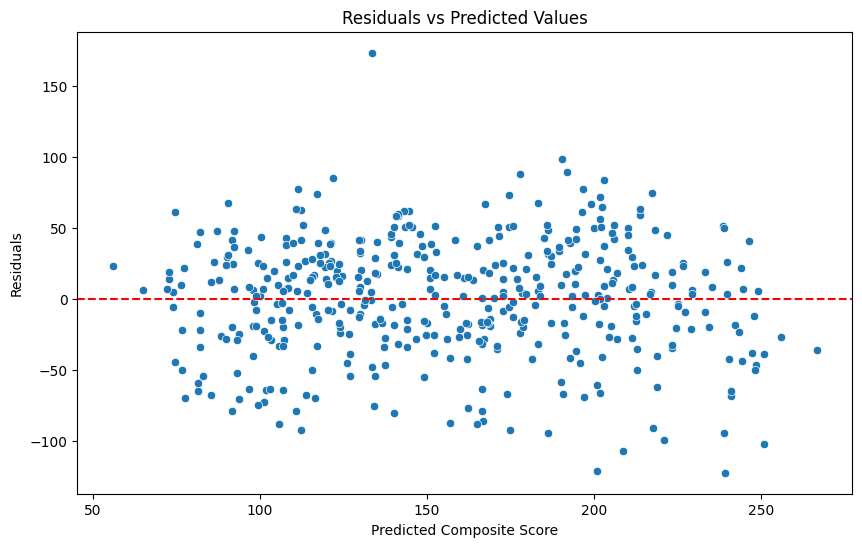

In [ ]:
# Make predictions on the validation set
y_pred = pipeline.predict(X_val)

# Compute residuals
residuals = y_val - y_pred

# Create a DataFrame to store actual values, predicted values, and residuals
results_df = X_val.copy()
results_df['Actual'] = y_val
results_df['Predicted'] = y_pred
results_df['Residual'] = residuals

# Plotting residuals against the predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Composite Score')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

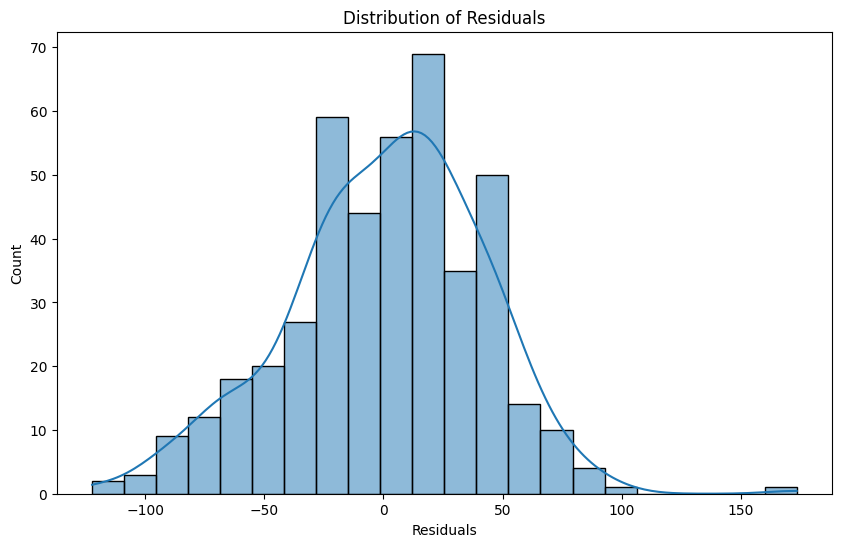

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()


In [ ]:
# Copy the results_df to avoid modifying the original DataFrame
results_df_mapped = results_df.copy()

# Function to map ordinal variables
def map_ordinal_variables(df, ordinal_mappings):
    df = df.copy()
    for col, mapping in ordinal_mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)
    return df

# Apply the mapping to results_df_mapped
results_df_mapped = map_ordinal_variables(results_df_mapped, ordinal_mappings)

In [ ]:
# Define age group labels corresponding to the mapped values
age_group_labels = {
    0: '49 or younger',
    1: '50–59',
    2: '60–69',
    3: '70–79',
    4: '80+'
}

# Map the numeric age values to labels
results_df_mapped['AgeGroup'] = results_df_mapped['age_12'].map(age_group_labels)

# Verify the mapping
print("Age groups after mapping:")
print(results_df_mapped['AgeGroup'].unique())


Age groups after mapping:
['60–69' '80+' '70–79' '50–59' nan]


In [ ]:
# Function to extract the age group label from the string
def extract_age_group(age_str):
    try:
        # Split the string at the first occurrence of '. '
        # This separates the group number from the age range
        _, age_group = age_str.split('. ', 1)
        return age_group.strip()
    except (ValueError, AttributeError):
        # If splitting fails or age_str is not a string, return NaN
        return np.nan

# Apply the function to the 'Age' column
results_df['AgeGroup'] = results_df['Age'].apply(extract_age_group)

# Display the unique age groups extracted
print("Extracted Age Groups:")
print(results_df['AgeGroup'].unique())

Extracted Age Groups:
['60–69' '80+' '70–79' '50–59' nan]


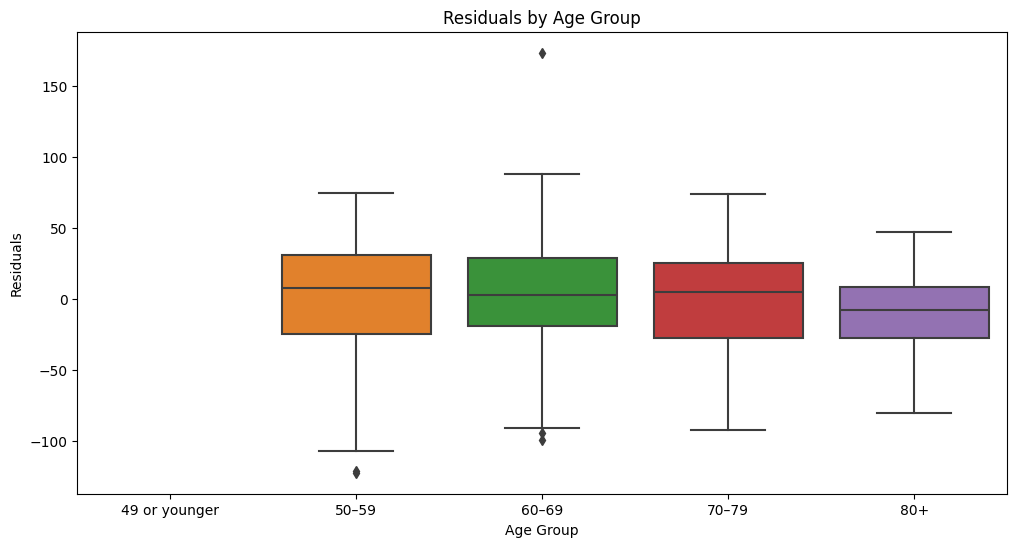

In [ ]:
# Define the order of age groups
age_group_order = ['49 or younger', '50–59', '60–69', '70–79', '80+']

plt.figure(figsize=(12, 6))
sns.boxplot(x='AgeGroup', y='Residual', data=results_df_mapped, order=age_group_order)
plt.xlabel('Age Group')
plt.ylabel('Residuals')
plt.title('Residuals by Age Group')
plt.show()


In [ ]:
from scipy.stats import f_oneway

# Group residuals by age group
groups = [group['Residual'].dropna() for name, group in results_df_mapped.groupby('AgeGroup') if name in age_group_order]

# Perform ANOVA
f_stat, p_value = f_oneway(*groups)
print(f'ANOVA Test for Age Groups: F-statistic={f_stat:.2f}, p-value={p_value:.4f}')


ANOVA Test for Age Groups: F-statistic=1.21, p-value=0.3040


In [ ]:
# Define education level labels
education_level_labels = {
    0: 'No education',
    1: '1–5 years',
    2: '6 years',
    3: '7–9 years',
    4: '10+ years'
}

# Map the numeric education levels to labels
results_df_mapped['EducationLevel'] = results_df_mapped['edu_gru_12'].map(education_level_labels)

# Verify the mapping
print("Education levels after mapping:")
print(results_df_mapped['EducationLevel'].unique())


Education levels after mapping:
['No education' '6 years' '1–5 years' '7–9 years' '10+ years' nan]


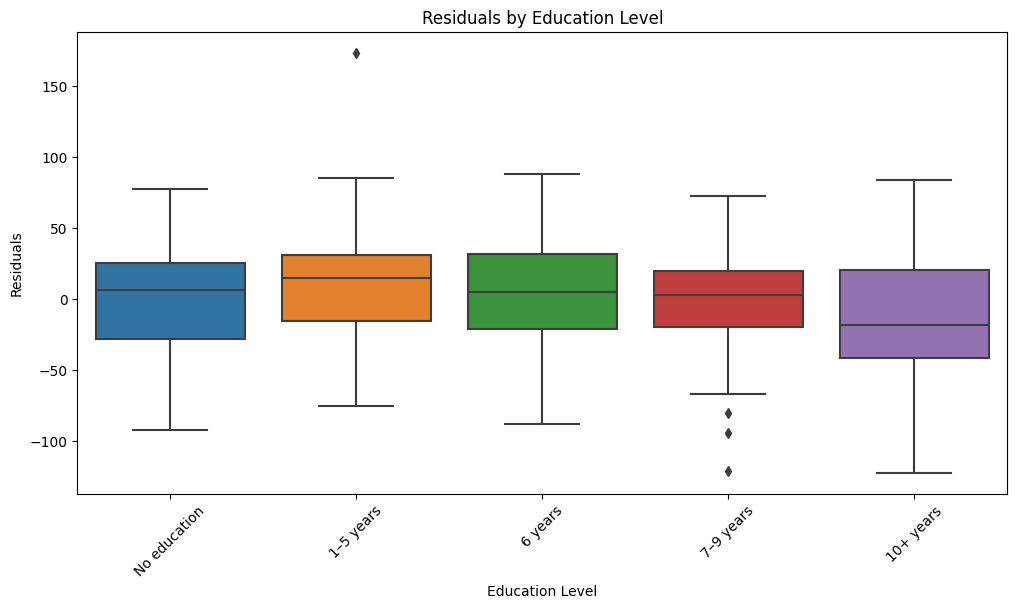

In [ ]:
# Define the order of education levels
education_level_order = ['No education', '1–5 years', '6 years', '7–9 years', '10+ years']

plt.figure(figsize=(12, 6))
sns.boxplot(x='EducationLevel', y='Residual', data=results_df_mapped, order=education_level_order)
plt.xlabel('Education Level')
plt.ylabel('Residuals')
plt.title('Residuals by Education Level')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Group residuals by education level
edu_groups = [group['Residual'].dropna() for name, group in results_df_mapped.groupby('EducationLevel') if name in education_level_order]

# Perform ANOVA
f_stat_edu, p_value_edu = f_oneway(*edu_groups)
print(f'ANOVA Test for Education Levels: F-statistic={f_stat_edu:.2f}, p-value={p_value_edu:.4f}')


ANOVA Test for Education Levels: F-statistic=3.48, p-value=0.0082


Since the p-value (0.0082) is less than the common significance level (α = 0.05), we reject the null hypothesis. This suggests that there is a statistically significant difference in the residuals among different education levels.

Implications
The significant difference in residuals implies that your model's prediction errors vary across education levels. This could indicate:

Bias in the Model: The model may systematically overestimate or underestimate the composite scores for certain education levels.

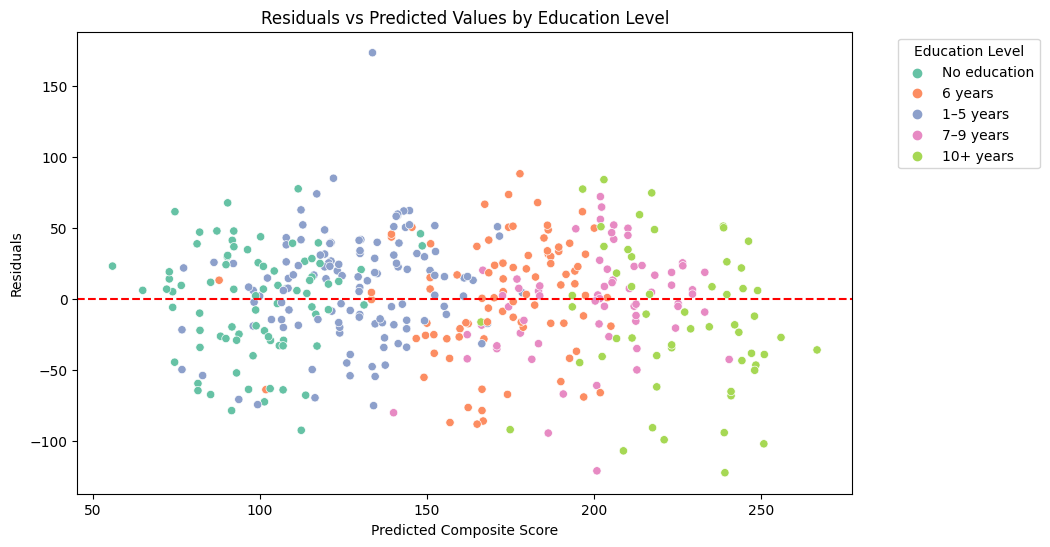

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Predicted', y='Residual', hue='EducationLevel', data=results_df_mapped, palette='Set2')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Composite Score')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values by Education Level')
plt.legend(title='Education Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
# Calculate mean residuals for each education level
mean_residuals = results_df_mapped.groupby('EducationLevel')['Residual'].mean().reindex(education_level_order)
print(mean_residuals)


EducationLevel
No education    -1.737545
1–5 years        8.723526
6 years          1.340764
7–9 years       -1.131326
10+ years      -14.875154
Name: Residual, dtype: float64


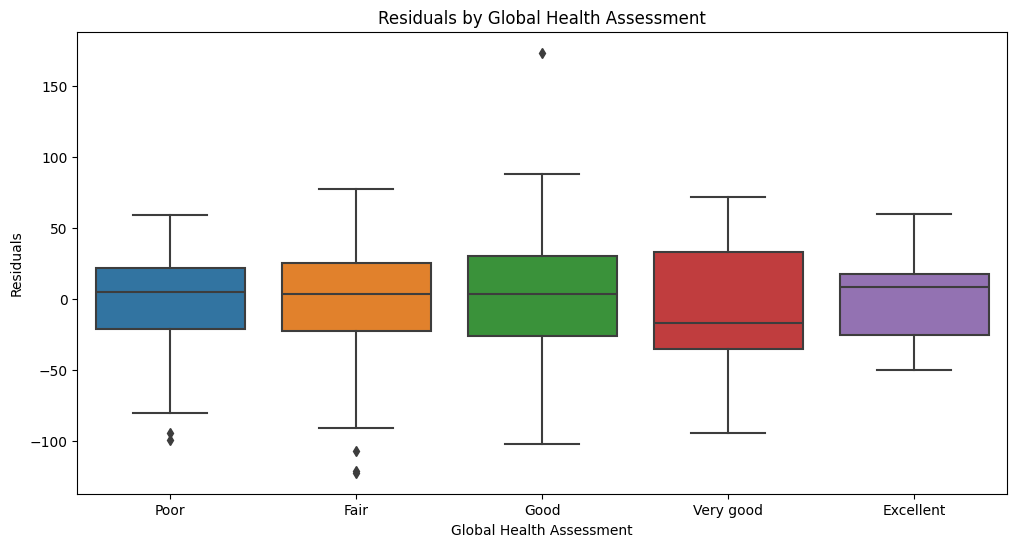

ANOVA Test for Global Health: F-statistic=0.47, p-value=0.7549


In [ ]:
# Map 'glob_hlth_12' using the mapping
results_df_mapped['GlobalHealth'] = results_df_mapped['glob_hlth_12']

# Define health labels (already mapped numerically)
global_health_labels = {
    5: 'Excellent',
    4: 'Very good',
    3: 'Good',
    2: 'Fair',
    1: 'Poor'
}

# Map numeric values to labels
results_df_mapped['GlobalHealth'] = results_df_mapped['GlobalHealth'].map(global_health_labels)

# Plot residuals by global health assessment
health_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']

plt.figure(figsize=(12, 6))
sns.boxplot(x='GlobalHealth', y='Residual', data=results_df_mapped, order=health_order)
plt.xlabel('Global Health Assessment')
plt.ylabel('Residuals')
plt.title('Residuals by Global Health Assessment')
plt.show()

# Perform ANOVA
health_groups = [group['Residual'].dropna() for name, group in results_df_mapped.groupby('GlobalHealth')]
f_stat_health, p_value_health = f_oneway(*health_groups)
print(f'ANOVA Test for Global Health: F-statistic={f_stat_health:.2f}, p-value={p_value_health:.4f}')

In [ ]:
# Select ordinal variables for correlation
ordinal_vars = ['age_12', 'edu_gru_12', 'n_living_child_12', 'glob_hlth_12', 'bmi_12']

# Compute correlation matrix
correlation_matrix = results_df_mapped[ordinal_vars + ['Residual']].corr()

# Display correlation with residuals
print("Correlation of ordinal variables with residuals:")
print(correlation_matrix['Residual'].drop('Residual'))


Correlation of ordinal variables with residuals:
age_12              -0.048635
edu_gru_12          -0.114082
n_living_child_12   -0.088456
glob_hlth_12         0.028826
bmi_12              -0.106816
Name: Residual, dtype: float64


In [ ]:
print(f"Number of rows in results_df_gender: {len(results_df_gender)}")


Number of rows in results_df_gender: 0


In [ ]:
print("Unique values in 'ragender':")
print(results_df['ragender'].unique())


Unique values in 'ragender':
['1.Man' '2.Woman']


Missing values in 'Gender': 0


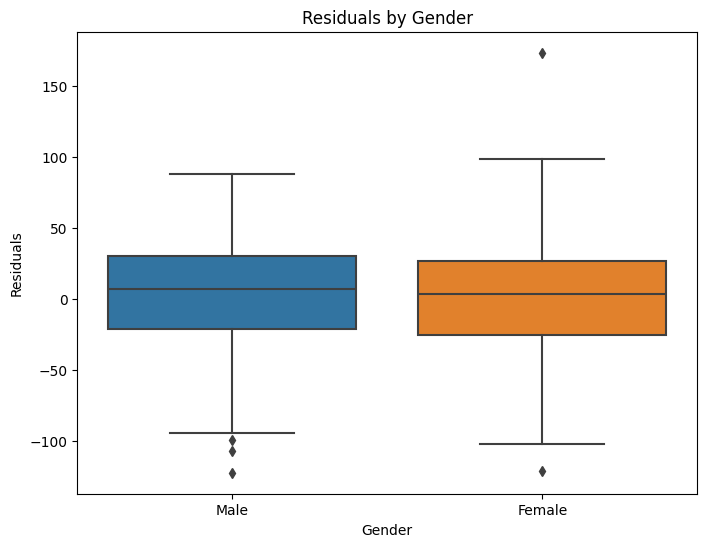

T-Test for Gender: t-statistic=0.74, p-value=0.4572


In [ ]:
# Assuming 'sgender' is coded as 1 for male and 0 for female
results_df['Gender'] = results_df['ragender'].map({
    '1.Man': 'Male',
    '2.Woman': 'Female'
})

# Check for missing values
missing_gender = results_df['Gender'].isna().sum()
print(f"Missing values in 'Gender': {missing_gender}")

# Drop rows with missing 'Gender' if necessary
results_df_gender = results_df.dropna(subset=['Gender'])

# Plot residuals by gender
plt.figure(figsize=(8, 6))
sns.boxplot(x='Gender', y='Residual', data=results_df_gender)
plt.xlabel('Gender')
plt.ylabel('Residuals')
plt.title('Residuals by Gender')
plt.show()

# Perform t-test
from scipy.stats import ttest_ind

residuals_male = results_df_gender[results_df_gender['Gender'] == 'Male']['Residual']
residuals_female = results_df_gender[results_df_gender['Gender'] == 'Female']['Residual']

t_stat, p_value = ttest_ind(residuals_male, residuals_female, nan_policy='omit')
print(f'T-Test for Gender: t-statistic={t_stat:.2f}, p-value={p_value:.4f}')


In [ ]:
print("Unique values in 'urban_12':")
print(results_df['urban_12'].unique())


Unique values in 'urban_12':
['0. <100,000' '1. 100,000+' nan]


In [ ]:
print(f"Number of rows in results_df_gender: {len(results_df_location)}")


Number of rows in results_df_gender: 0


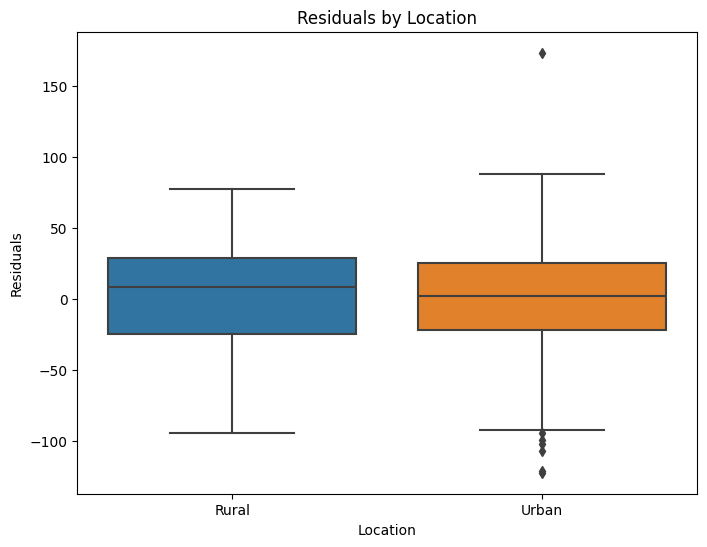

T-Test for Location: t-statistic=-0.46, p-value=0.6490


In [ ]:
# Assuming 'urban_rural' indicates urban (1) or rural (0) areas
results_df['Location'] = results_df['urban_12'].map({'1. 100,000+': 'Urban', '0. <100,000': 'Rural'})

# Handle missing values
results_df_location = results_df.dropna(subset=['Location'])

# Plot residuals by location
plt.figure(figsize=(8, 6))
sns.boxplot(x='Location', y='Residual', data=results_df_location)
plt.xlabel('Location')
plt.ylabel('Residuals')
plt.title('Residuals by Location')
plt.show()

# Perform t-test
residuals_urban = results_df_location[results_df_location['Location'] == 'Urban']['Residual']
residuals_rural = results_df_location[results_df_location['Location'] == 'Rural']['Residual']

t_stat_loc, p_value_loc = ttest_ind(residuals_urban, residuals_rural, nan_policy='omit')
print(f'T-Test for Location: t-statistic={t_stat_loc:.2f}, p-value={p_value_loc:.4f}')


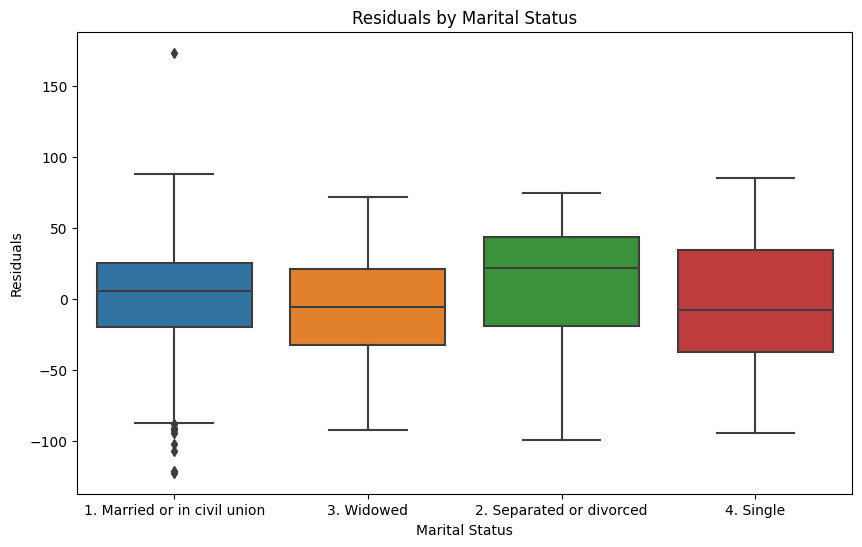

ANOVA Test for Marital Status: F-statistic=0.95, p-value=0.4142


In [ ]:
# Map 'married_12' to categories if necessary
results_df['MaritalStatus'] = results_df['married_12']

# Handle missing values
results_df_marital = results_df.dropna(subset=['MaritalStatus'])

# Plot residuals by marital status
plt.figure(figsize=(10, 6))
sns.boxplot(x='MaritalStatus', y='Residual', data=results_df_marital)
plt.xlabel('Marital Status')
plt.ylabel('Residuals')
plt.title('Residuals by Marital Status')
plt.show()

# ANOVA test
marital_groups = [group['Residual'].dropna() for name, group in results_df_marital.groupby('MaritalStatus')]
f_stat_marital, p_value_marital = f_oneway(*marital_groups)
print(f'ANOVA Test for Marital Status: F-statistic={f_stat_marital:.2f}, p-value={p_value_marital:.4f}')


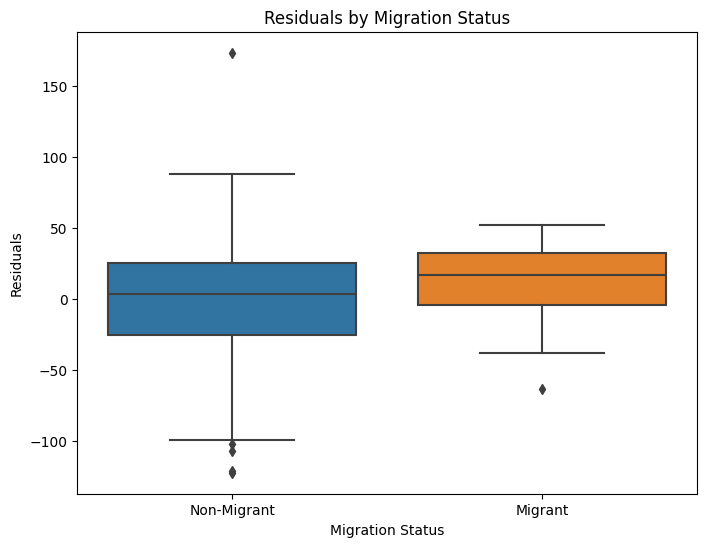

T-Test for Migration Status: t-statistic=1.27, p-value=0.2031


In [ ]:
# 'migration_12' is 1 if lived/worked in the U.S., 0 otherwise
results_df['MigrationStatus'] = results_df['migration_12'].map({1: 'Migrant', 0: 'Non-Migrant'})

# Handle missing values
results_df_migration = results_df.dropna(subset=['MigrationStatus'])

# Plot residuals by migration status
plt.figure(figsize=(8, 6))
sns.boxplot(x='MigrationStatus', y='Residual', data=results_df_migration)
plt.xlabel('Migration Status')
plt.ylabel('Residuals')
plt.title('Residuals by Migration Status')
plt.show()

# T-test
residuals_migrants = results_df_migration[results_df_migration['MigrationStatus'] == 'Migrant']['Residual']
residuals_non_migrants = results_df_migration[results_df_migration['MigrationStatus'] == 'Non-Migrant']['Residual']

t_stat_mig, p_value_mig = ttest_ind(residuals_migrants, residuals_non_migrants, nan_policy='omit')
print(f'T-Test for Migration Status: t-statistic={t_stat_mig:.2f}, p-value={p_value_mig:.4f}')


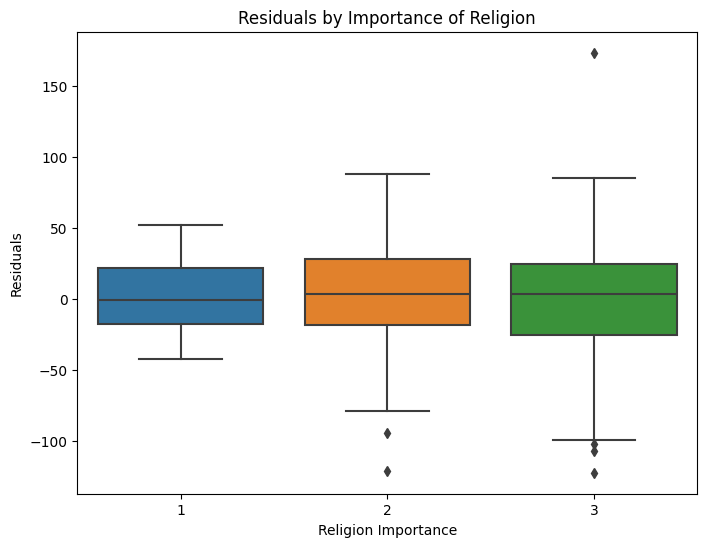

ANOVA Test for Religion Importance: F-statistic=0.57, p-value=0.5637


In [ ]:
# Map 'rrelgimp_12' using the provided mapping
religion_importance_mapping = {
    '1.very important': 3,
    '2.somewhat important': 2,
    '3.not important': 1,
}
results_df['ReligionImportance'] = results_df['rrelgimp_12'].map(religion_importance_mapping)

# Handle missing values
results_df_religion = results_df.dropna(subset=['ReligionImportance'])

# Plot residuals by religion importance
religion_order = [1, 2, 3]  # Not important to very important
plt.figure(figsize=(8, 6))
sns.boxplot(x='ReligionImportance', y='Residual', data=results_df_religion, order=religion_order)
plt.xlabel('Religion Importance')
plt.ylabel('Residuals')
plt.title('Residuals by Importance of Religion')
plt.show()

# ANOVA test
religion_groups = [group['Residual'].dropna() for name, group in results_df_religion.groupby('ReligionImportance')]
f_stat_religion, p_value_religion = f_oneway(*religion_groups)
print(f'ANOVA Test for Religion Importance: F-statistic={f_stat_religion:.2f}, p-value={p_value_religion:.4f}')


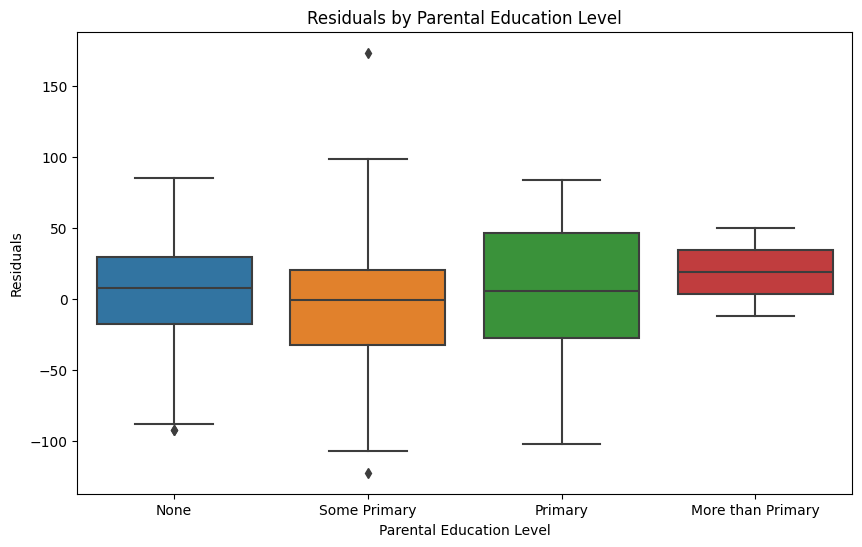

ANOVA Test for Parental Education: F-statistic=1.44, p-value=0.2318


In [ ]:
# Map 'rameduc_m' and 'rafeduc_m' using the parent education mapping
parent_education_mapping = {
    '1.None': 1,
    '2.Some primary': 2,
    '3.Primary': 3,
    '4.More than primary': 4,
}

results_df['MotherEducation'] = results_df['rameduc_m'].map(parent_education_mapping)
results_df['FatherEducation'] = results_df['rafeduc_m'].map(parent_education_mapping)

# Handle missing values
results_df_parents = results_df.dropna(subset=['MotherEducation', 'FatherEducation'])

# Create a combined parental education score
results_df_parents['ParentalEducation'] = results_df_parents[['MotherEducation', 'FatherEducation']].mean(axis=1)

# Create bins for parental education levels
results_df_parents['ParentalEducationLevel'] = pd.cut(results_df_parents['ParentalEducation'], bins=[0, 1.5, 2.5, 3.5, 4], labels=['None', 'Some Primary', 'Primary', 'More than Primary'])

# Plot residuals by parental education level
plt.figure(figsize=(10, 6))
sns.boxplot(x='ParentalEducationLevel', y='Residual', data=results_df_parents)
plt.xlabel('Parental Education Level')
plt.ylabel('Residuals')
plt.title('Residuals by Parental Education Level')
plt.show()

# ANOVA test
parent_edu_groups = [group['Residual'].dropna() for name, group in results_df_parents.groupby('ParentalEducationLevel')]
f_stat_parent_edu, p_value_parent_edu = f_oneway(*parent_edu_groups)
print(f'ANOVA Test for Parental Education: F-statistic={f_stat_parent_edu:.2f}, p-value={p_value_parent_edu:.4f}')


# Model Interpretability

## Retrieving Feature Names after preprocessing


In [ ]:
# Function to get feature names
def get_feature_names(preprocessor):
    feature_names = []
    
    preprocessing = preprocessor.named_steps['preprocessing']
    
    for name, transformer, columns in preprocessing.transformers_:
        if transformer == 'drop' or len(columns) == 0:
            continue
        elif transformer == 'passthrough':
            feature_names.extend(columns)
        else:
            # The transformer is a Pipeline
            if hasattr(transformer, 'named_steps'):
                last_step = transformer.steps[-1][1]
            else:
                last_step = transformer
                
            if hasattr(last_step, 'get_feature_names_out'):
                print(f"\nTransformer: {name}")
                print(f"Columns passed: {len(columns)} columns")
                print(f"Columns names: {columns}")
                if hasattr(last_step, 'n_features_in_'):
                    print(f"Transformer n_features_in_: {last_step.n_features_in_}")
                else:
                    print("Transformer does not have 'n_features_in_' attribute.")
                
                if hasattr(last_step, 'feature_names_in_'):
                    print(f"Transformer feature_names_in_: {last_step.feature_names_in_}")
                else:
                    print("Transformer does not have 'feature_names_in_' attribute.")
                
                if isinstance(last_step, OneHotEncoder):
                    # For OneHotEncoder, pass the original column names
                    names = last_step.get_feature_names_out(columns)
                else:
                    # For other transformers, use columns as feature names
                    names = columns
                feature_names.extend(names)
            else:
                # If transformer doesn't have get_feature_names_out, use the column names
                feature_names.extend(columns)
    return feature_names

# Retrieve the feature names
feature_names = get_feature_names(preprocessor)

# Print the feature names
print("\nFeature Names:")
for name in feature_names:
    print(name)


Transformer: num
Columns passed: 261 columns
Columns names: ['n_depr_03', 'iadl_meds_change', 'attends_club_12', 'volunteer_12', 'year', 'total_adl_limitations_12', 'out_proc_03', 'hinc_business_12', 'pem_def_mar_03', 'issste_change', 'hinc_cap_12', 'care_child_12', 'test_chol_change', 'adl_toilet_03', 'adl_dress_12', 'sinc_pension_change', 'sad_change', 'cesd_depressed_12', 'lonely_03', 'hrt_attack_12', 'energetic_03', 'n_illnesses_12', 'preventive_care_change', 'adl_eat_12', 'cancer_12', 'insured_change', 'visit_dental_12', 'searnings_03', 'adl_bath_12', 'tired_change', 'adl_iadl_progression', 'stroke_03', 'depressed_change', 'positive_mood_change', 'tobacco_change', 'imss_12', 'adl_walk_change', 'sgender_change', 'hinc_cap_change', 'imss_03', 'sewing_12', 'hinc_assets_03', 'urban_change', 'time_gap', 'insur_private_change', 'rinc_pension_03', 'restless_12', 'restless_change', 'stroke_change', 'hincome_03', 'negative_mood_score_03', 'exer_3xwk_change', 'insured_03', 'issste_12', 'in